In [1]:
import importlib.util
import sys
loc = '/afs/ciemat.es/user/m/martialc/public/muTel_v4/muTel/src/muTel/__init__.py'
# loc = r'..\..\..\src\muTel\__init__.py'
src = 'muTel'
spec = importlib.util.spec_from_file_location(src, loc)
foo = importlib.util.module_from_spec(spec)
sys.modules[src] = foo
spec.loader.exec_module(foo)
%load_ext autoreload

In [2]:
from IPython.display import display
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyarrow.parquet as pq
import pyarrow as pa
import os
from timeit import default_timer as timer
from scipy.optimize import curve_fit
from pprint import pprint

import muTel.utils.meta as meta
from muTel.utils.tools import flatten_dict
from muTel.utils.units import Time

from muTel.dqm import MuData, MuEvent, MuChamber

# Reading and handling data

## MuData

This class uses `Dask.DataFrame` to import `.parquet` files where each row is a hit and each column contains the caracterization of each hit.

We can read a file in this format using the methods `MuData.from_path` providing the path to a `.parquet` file or we can call `MuData.from_datadir` to read a file from the `data` directory in the package.

In [3]:
mudata = MuData.from_datadir('run_588')
mudata

,EventNr,GEO,hit,channel,chamber,sl,layer,cell,TDCtime,DriftTime
npartitions=5,,,,,,,,,,
,int32,int8,int16,int8,int64,int8,int8,int8,int16,float64
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


You can also select a sample of size `n` to work on a smaller dataset. 

In [4]:
n = 100
mudata.sample(n)

,EventNr,GEO,hit,channel,chamber,sl,layer,cell,TDCtime,DriftTime
npartitions=5,,,,,,,,,,
,int32,int8,int16,int8,int64,int8,int8,int8,int16,float64
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


You can also select an event using Python notation, which returns a MuData object with the selected EventNr.

In [5]:
mudata[1].df

,EventNr,GEO,hit,channel,chamber,sl,layer,cell,TDCtime,DriftTime
0,1,26,1,35,1,3,1,9,1500,721.87500
1,1,26,5,91,1,4,1,7,1853,997.65625
2,1,26,4,93,1,4,2,8,1618,814.06250
3,1,26,3,92,1,4,4,8,1587,789.84375
4,1,26,2,36,1,3,4,10,1937,1063.28125
5,1,26,0,34,1,3,3,9,1505,725.78125
6,1,24,3,35,1,1,1,9,1920,1050.00000
7,1,24,6,96,1,2,4,9,1729,900.78125
8,1,24,5,94,1,2,3,8,1701,878.90625
9,1,24,4,95,1,2,1,8,1674,857.81250


This class really doesn't do much on its own, it is mostly used for handling data in a lazy way. Of course, the functionality of this class may be expanded.

# Pairing

## MuEvent

With MuData we can construct a MuEvent containing the hits associated to each EventNr. We will use event `1830` to demonstrate the algorithm I've developed for pairing the hits. This is an improved approach from the simple selection I used in my Master's thesis, where I chose the hits with the lowest drift time in each layer.

In [6]:
event = MuEvent.from_MuData(mudata[1830])
event.data.sort_values(['sl','layer','cell'], ascending= [True,False,True])

,EventNr,GEO,hit,channel,chamber,sl,layer,cell,TDCtime,DriftTime
482,1830,24,34,4,1,1,4,2,1647,172.65625
496,1830,24,0,4,1,1,4,2,1452,20.31250
542,1830,24,69,4,1,1,4,2,7500,4745.31250
556,1830,24,61,4,1,1,4,2,2135,553.90625
486,1830,24,38,8,1,1,4,3,1545,92.96875
...,...,...,...,...,...,...,...,...,...,...
200,1830,26,310,123,1,4,1,15,1467,32.03125
248,1830,26,358,123,1,4,1,15,7502,4746.87500
276,1830,26,338,123,1,4,1,15,1915,382.03125
203,1830,26,313,127,1,4,1,16,1465,30.46875


In SL1 we have now 2 hits in layers 4 and 3 (and 2 and 1). This will be usefull to demonstrate the performance for multiple muon events.

In [7]:
layer_i = 4
layer_j = 3

assert layer_i > layer_j

hits_layer_i = event.data[(event.data.sl == 1) & (event.data.layer == layer_i)]
hits_layer_j = event.data[(event.data.sl == 1) & (event.data.layer == layer_j)]


display(hits_layer_i, hits_layer_j)

,EventNr,GEO,hit,channel,chamber,sl,layer,cell,TDCtime,DriftTime
385,1830,24,129,32,1,1,4,9,1863,341.40625
389,1830,24,133,36,1,1,4,10,1837,321.09375
393,1830,24,137,40,1,1,4,11,1886,359.37500
399,1830,24,119,52,1,1,4,14,1648,173.43750
402,1830,24,99,36,1,1,4,10,1458,25.00000
403,1830,24,100,52,1,1,4,14,1457,24.21875
404,1830,24,101,56,1,1,4,15,1456,23.43750
405,1830,24,102,60,1,1,4,16,1457,24.21875
410,1830,24,141,44,1,1,4,12,1887,360.15625
415,1830,24,112,44,1,1,4,12,1471,35.15625


,EventNr,GEO,hit,channel,chamber,sl,layer,cell,TDCtime,DriftTime
380,1830,24,124,58,1,1,3,15,1473,36.71875
383,1830,24,127,62,1,1,3,16,1462,28.12500
387,1830,24,131,34,1,1,3,9,1863,341.40625
391,1830,24,135,38,1,1,3,10,1838,321.87500
395,1830,24,139,42,1,1,3,11,1887,360.15625
397,1830,24,121,54,1,1,3,14,1472,35.93750
401,1830,24,98,34,1,1,3,9,1459,25.78125
409,1830,24,106,38,1,1,3,10,1472,35.93750
413,1830,24,110,42,1,1,3,11,1473,36.71875
417,1830,24,114,46,1,1,3,12,1471,35.15625


In [8]:
layer_sep = np.abs(layer_j - layer_i)



# To assert that the hits come from the same muon, we check the "distance" between each pair of cells from different layers
hit_diff = np.r_[hits_layer_j.hit] - np.c_[hits_layer_i.hit]
cell_diff = np.r_[hits_layer_j.cell] - np.c_[hits_layer_i.cell]

# We need to compensate the difference to take into account the staggering.
if layer_sep % 2 == 1:
    if (layer_i % 2 == 0):
        cell_diff = cell_diff + 0.5
    else:
        cell_diff = cell_diff - 0.5

# Now if cell_diff is contiguous and to the left of the upper cell, it will have a value of -0.5. In case it is contiguous and
# to the right, it will have a value of 0.5. Any other values indicate that the cells are not contiguous.



If we want to take into account the possibility of two muons passing through the same cells or cells compatible with a trace,
we need to account for the difference in time between the hits.

Right now, the algorithm uses a legacy field called "hits", which is a counter given by the readout, which is a rough
approximation to an order of arrival. With the new data format, this is likely to be changed.

To find the pair of hits most likely to come from the same muon, we then will check the minimum of each row and column. This is, we need to find the hit `j` in the top layer that has the minimum distance with respect to hit `i` in the bottom layer (rows) and viceversa. Once we have the minimum for each row (column) we now check that they are the same pair. In that case, we select them.

In [9]:
total_diff = np.abs(hit_diff) + np.where(np.abs(cell_diff) <= layer_sep/2, 0, np.inf)

where_j_min = [[i,e] for i,e in enumerate(total_diff.argmin(axis=1))] # Mínimo de cada fila.
where_i_min = [[e,i] for i,e in enumerate(total_diff.argmin(axis=0))] # Mínimo de cada columna.


# Now we can check the indexes where the pair of hits are produced in contiguous cells.
is_cont  = np.c_[np.where(np.abs(cell_diff) <= layer_sep/2)].tolist()

# We check the intersection of both sets to obtain the pairs where the minimum coincides and then
# we select only the ones where the cells were contiguous.
min_coincidence = set(tuple(pair) for pair in where_i_min).intersection(set(tuple(pair) for pair in where_j_min))
pairs = list(min_coincidence.intersection(set(tuple(pair) for pair in is_cont)))

pairs

[(43, 43),
 (4, 6),
 (33, 30),
 (0, 2),
 (9, 8),
 (15, 14),
 (25, 22),
 (18, 13),
 (20, 16),
 (26, 38),
 (40, 37),
 (48, 50),
 (7, 0),
 (32, 29),
 (35, 31),
 (12, 11),
 (42, 46),
 (21, 17),
 (3, 5),
 (38, 36),
 (39, 40),
 (10, 7),
 (27, 23),
 (45, 44),
 (28, 25),
 (37, 34),
 (13, 12),
 (24, 21)]

Here we have a visual help to see what the algorithm is doing:

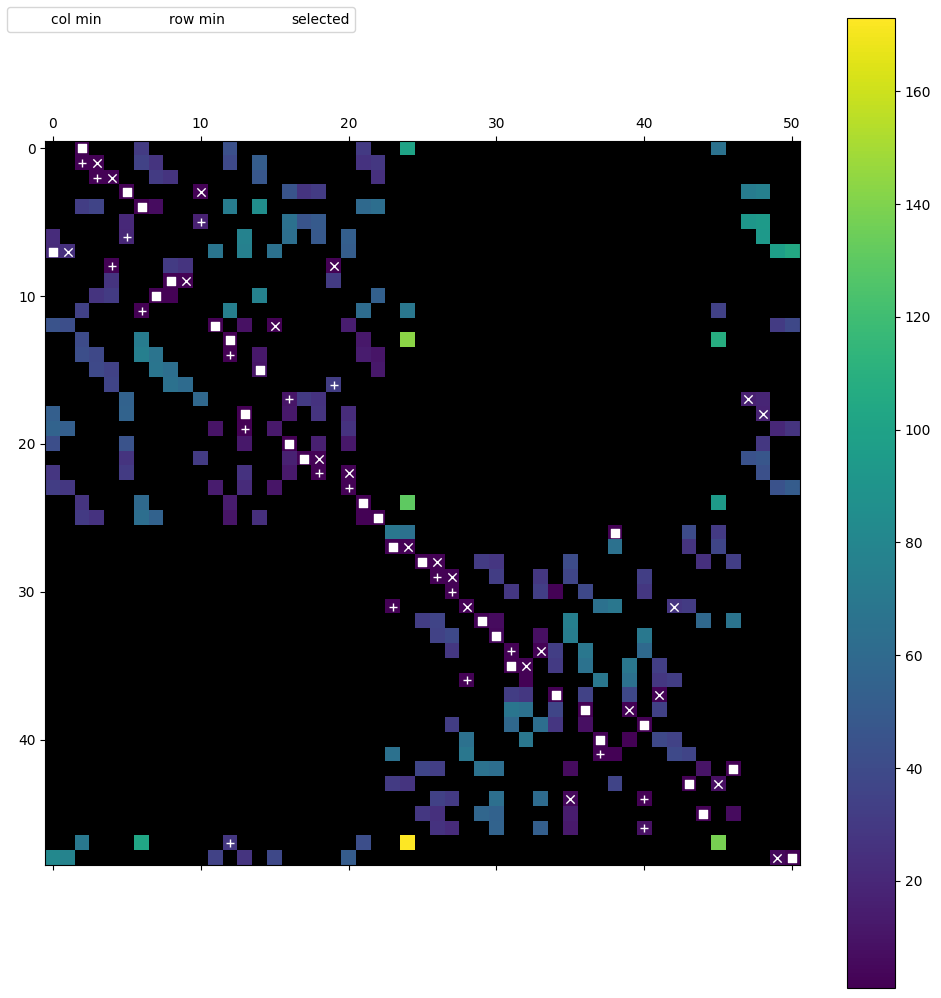

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
cm = mpl.colormaps.get_cmap('viridis')
cm.set_bad('k')
artist = ax.matshow(total_diff,cmap=cm)
fig.colorbar(artist,ax = ax)

ax.scatter(
        *np.c_[where_j_min].T[::-1],
        marker='+',
        color='w',
        linewidth = 1,
        label   = 'col min',
        zorder = 4
    )

ax.scatter(
        *np.c_[where_i_min].T[::-1],
        marker='x',
        color='w',
        linewidth = 1,
        label   = 'row min',
        zorder = 4
    )

ax.scatter(
        *np.c_[list(pairs)].T[::-1],
        marker='s',
        color='w',
        linewidth = 1,
        label='selected',
        # facecolor='none'
    )

fig.legend(loc=2, ncols=3)
fig.tight_layout()

Some cases are not paired but could be allowed. This is likely because the muon has triggered two contiguous cells in a layer and the algorithm can only pair a hit once.

Once the hits are paired (`MuLE` object) or left as Standalone Hits (`MuSH` object), they are "yoked" together because the pairing is independent between layer pairs. The objects returned from this process (`MuSE` objects) are then stored in the `MuEvent` object for further manipulation.

To accelerate this process, I've made a script that uses a given number of CPU cores to run each event as a separated process and then writes the resulting `MuSE`s to disk in `.parquet` format. This way, the consumption of memory is decreased.

# Fitting traces

Once the `MuSE` file is generated, we can read it and start the fitting process for the segments defined in each `MuSE`. The parallelization of this process is still ongoing, but the functions are ready to fit.

## MuSL and MuChamber

These two classes are the ones that contain the information about the experimental setting. `MuSL` contains information abou the cell width, cell height, number of cells, number of layers, etc. whereas `MuChamber` is a set of `MuSL` where each one of them may be different and is built using a template read from a config file (in `.yaml` format, but a `.json` could be used as well), one for the [chamber setup](/afs/ciemat.es/user/m/martialc/public/muTel_v4/muTel/src/muTel/dqm/cfg/muTel/chambers.yaml) and one for the [Superlayer templates](/afs/ciemat.es/user/m/martialc/public/muTel_v4/muTel/src/muTel/dqm/cfg/muTel/superlayers.yaml).

We can have multiple configurations stored in the config folder and they may be loaded using the `MuChamber` class as follows:



In [11]:
mutel = MuChamber.from_preset('muTel','default','muTel')
display(mutel, mutel.superlayers)

MuChamber(muTel)

{1: SL1 (SN) @ muTel,
 2: SL2 (EW) @ muTel,
 3: SL3 (SN) @ muTel,
 4: SL4 (EW) @ muTel}

Now that a `MuChamber` istance has been created, it may be accessible to the `MuSE` objects from `MuChamber._current_chamber`, this allows the fitting of the trace to be dependant on the chamber setting we have defined.

## Reading and fitting MuSE

Right now, there is no function or class that handles reading the parquet file and recreating each `MuEvent`. For the time being, we may call the `MuEvent` builder that is designed to read a `pandas.DataFrame` and recreate the `MuSE` instances that were computed in the previous steps.

In [12]:
muse_data = pd.read_parquet('/afs/ciemat.es/user/m/martialc/public/muTel_v4/muTel/data/muse/run_588.parquet',engine='pyarrow')
event = MuEvent.from_musedata(muse_data[muse_data.EventNr == 0])
event.data

,EventNr,GEO,hit,channel,sl,layer,cell,TDCtime,DriftTime,MuSEId
5,0,24,4,20,1,4,6,1822,969.53125,0A
2,0,24,1,22,1,3,6,1698,872.65625,0A
3,0,24,2,21,1,2,6,1730,897.65625,0A
4,0,24,3,23,1,1,6,1741,906.25000,0A
7,0,24,6,76,2,4,4,1684,861.71875,0B
6,0,24,5,78,2,3,4,1638,825.78125,0B
9,0,24,8,77,2,2,4,1763,923.43750,0B
8,0,24,7,79,2,1,4,1732,899.21875,0B
11,0,26,1,16,3,4,5,1719,889.06250,0C
12,0,26,2,18,3,3,5,1762,922.65625,0C


To fit each segment in this event we may use the keyword argument `do_fit` and set it to `True` (it is set to `False` by default). We can also fit each `MuSE` individually to study the selection of the laterality of each hit or we can plot the best fit for each `MuSE`.

SOUTH-NORTH AXIS


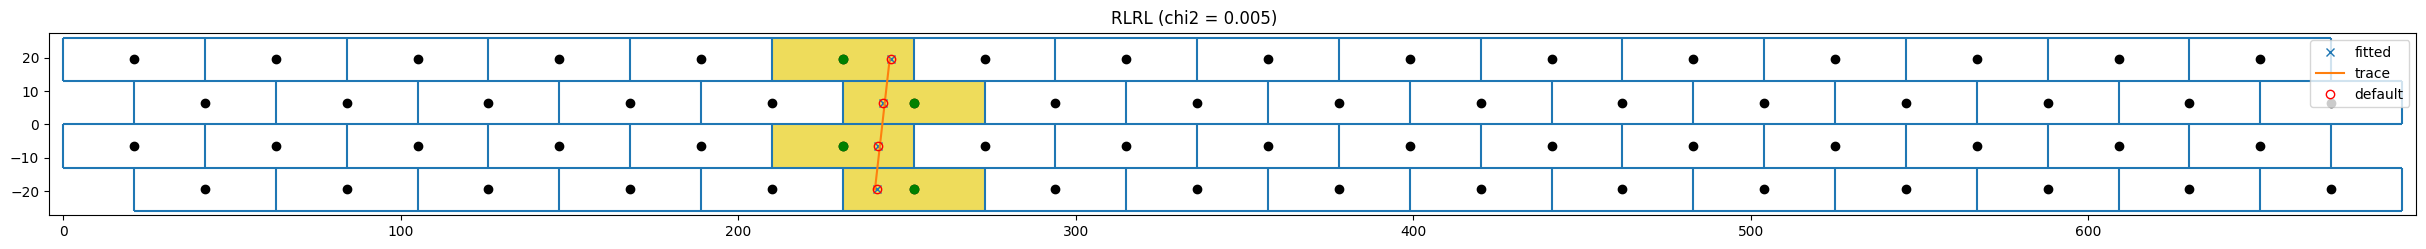

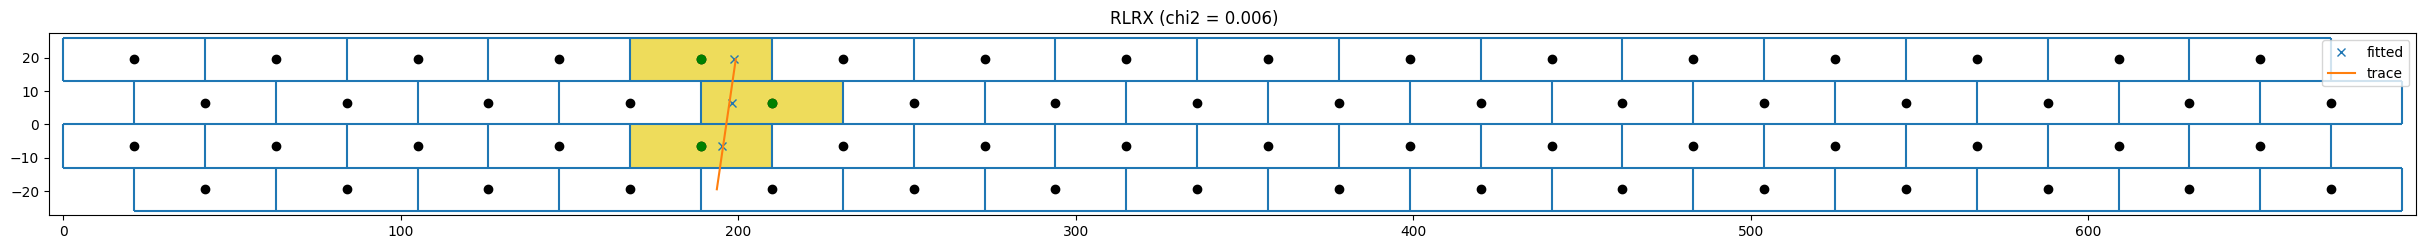

EAST-WEST AXIS


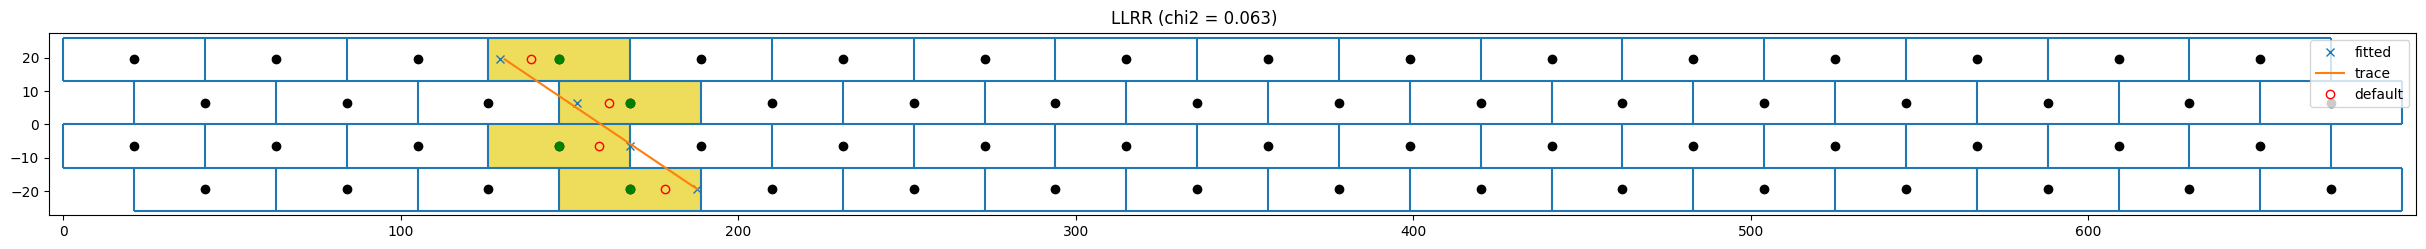

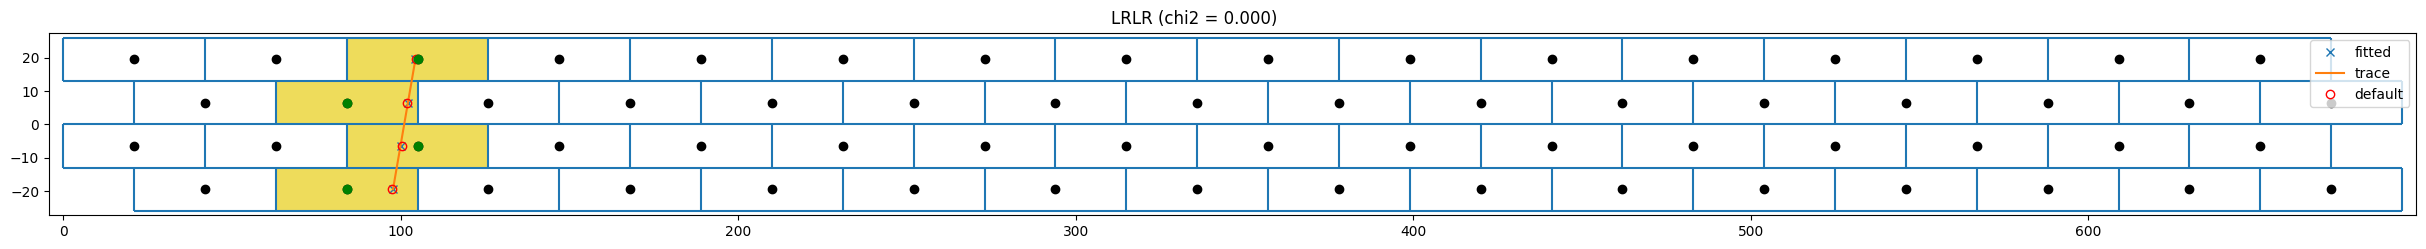

In [13]:
plt.ioff()
figs_slX = [muse.fit(do_plot=True).fig.values[0] for muse in event.all_muses if (muse.nhits > 2) & (muse.sl % 2 == 1)]
figs_slY = [muse.fit(do_plot=True).fig.values[0] for muse in event.all_muses if (muse.nhits > 2) & (muse.sl % 2 == 0)]
plt.close('all')

plt.ion()
print('SOUTH-NORTH AXIS')
for fig in figs_slX:
    plt.figure(fig)
    plt.show()

print('EAST-WEST AXIS')
for fig in figs_slY:
    plt.figure(fig)
    plt.show()

In this stage, the fitting has some limitations when it comes to certain geometric configurations of the traces, as may be seen in SL2 (first figure under EAST-WEST AXIS). We may study the different laterality combinations possible for this cell pattern.

,phi,x0,t0,res,chi2,x0_dev,t0_dev,fig
latID,,,,,,,,
LLRR,-0.971846,159.358398,541.619318,"[-1.3964843611512094, 2.5351562545031356, -0.8...",0.062752,1.858398,-168.380682,Figure(3054.55x236.364)
RLRL,0.012394,158.327148,685.165128,"[-1.8583984375005969, 1.8583984375013927, 1.85...",0.087253,0.827148,-24.834872,Figure(3054.55x236.364)
RLRR,-0.483854,164.036412,691.609172,"[2.5672433035686026, 9.947598300641403e-13, -7...",0.548350,6.536412,-18.390828,Figure(3054.55x236.364)
LLRL,-0.375337,154.829241,734.522119,"[-7.14174112667996, 10.71261160464789, -4.5270...",1.178758,-2.670759,24.522119,Figure(3054.55x236.364)


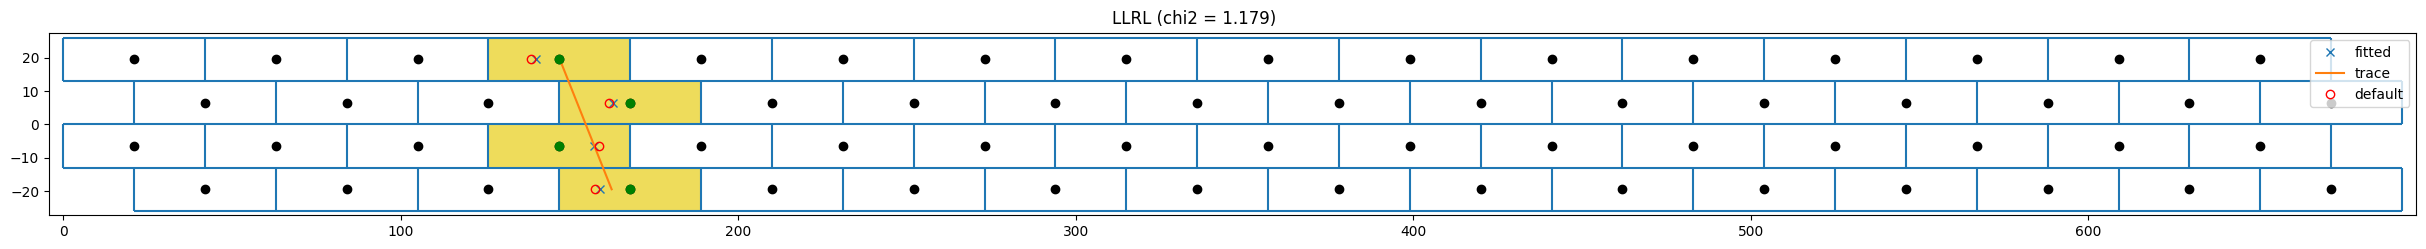

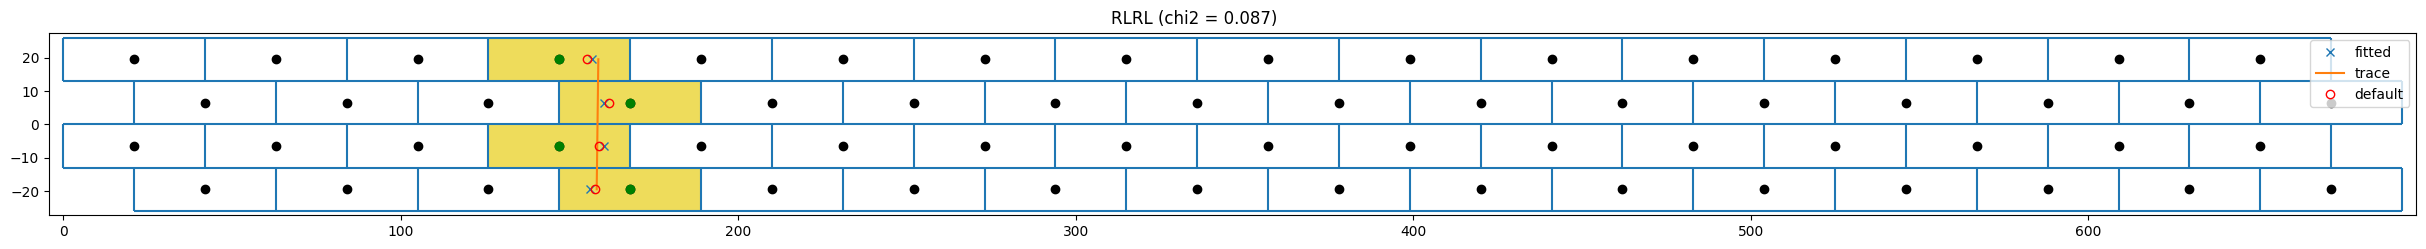

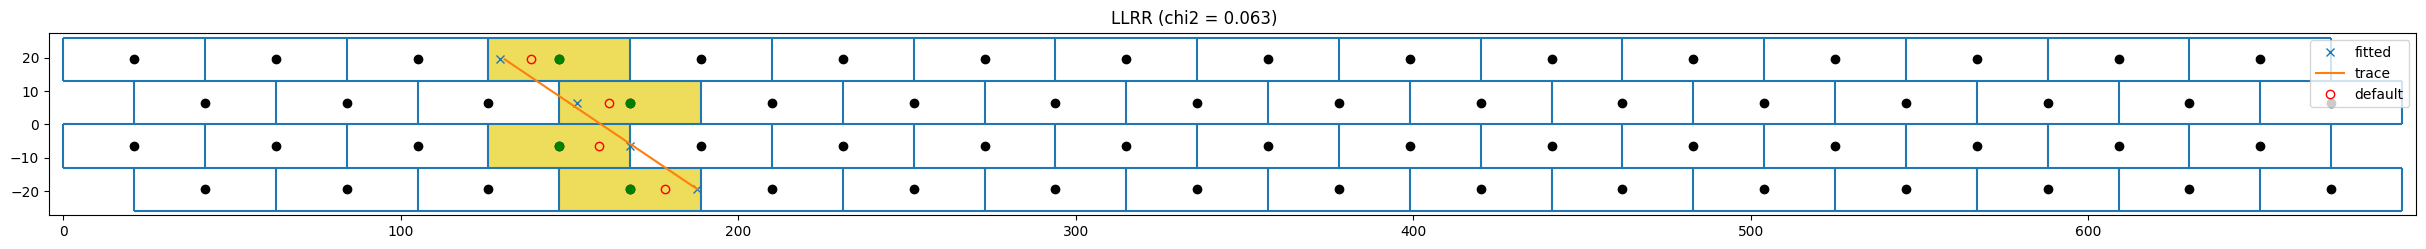

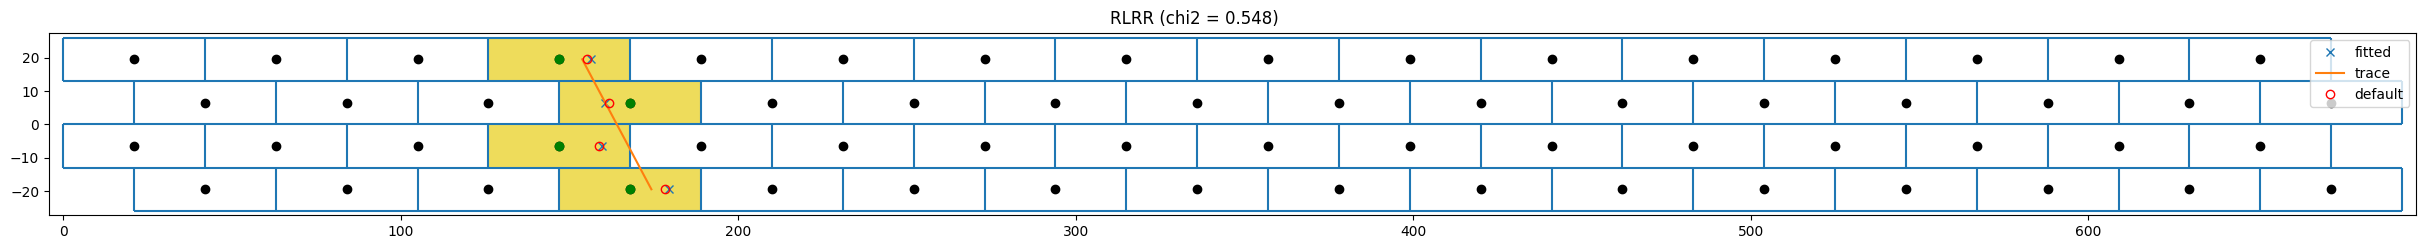

In [ ]:
event.muses[4][0].fit(do_plot=True)

We can see that the RLRL is the one that fits the best to what we could expect to be the reconstructed trace, however, the LLRR is the fit that minimizes the chi2 value. This in turn is giving an unexpected value of the incidence angle which is causing the trace to have a kink between layers SL2 and SL4.

A solution I've thought of is to provide a maximum and minimum angle for each pattern and write it in the configuration file containing the different [cell patterns](/afs/ciemat.es/user/m/martialc/public/muTel_v4/muTel/src/muTel/dqm/cfg/muTel/pattern.json).